In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jwave.geometry import Domain

# Simulation parameters
dt = 0.01
c_ref = 1.
dx = 1.

# Domain
domain = Domain((128,128), (dx,dx))

# k-Wave equations

With don't consider absorption for the moment. The equations are

$$
\begin{align}
\partial_t \mathbf{u} &= -\frac{1}{\rho_0}\nabla p \\
\partial_t \rho &= -\rho_0\nabla \cdot \mathbf{u} - \mathbf{u} \cdot \nabla \rho_0 \\
\partial_t \mathbf{d} &= \mathbf{u} \\
\\
p &= c_0^2 \rho
\end{align}
$$

We are now going to reproduce k-Wave by building up the required numerical operators one by one, and then joining them up using an ODE integrator.

### Staggered derivative operators
For stability reasons, we want to modify the derivative operators such that they work on staggered grids for Spectral and Finite Difference methods. We want also to modify the Spectral operator to include an extra k-space operator to improve the accuracy of the simulation

The easiest way to do this is to extend the base classes with new ones, that have a common operator that computes such modified derivatives.

In [3]:
from jwave.primitives import Primitive
from jax import numpy as jnp
from jax.tree_util import tree_map
from enum import IntEnum

class Staggered(IntEnum):
    NONE = 0
    FORWARD = 1
    BACKWARD = -1

class FFTStaggeredGrad(Primitive):
    def __init__(
        self, 
        name="FFTStaggeredGrad",
        c_ref=1.,
        dt = 1.,
        direction=Staggered.NONE,
        independent_params=False
    ):
        super().__init__(name, independent_params)
        self.direction = direction
        self.c_ref = c_ref
        self.dt = dt
        
    def setup(self, field):
        def f(N, dx):
            return jnp.fft.fftfreq(N, dx) * 2 * jnp.pi
        domain = field.discretization.domain
        k_vec = [f(n, delta) for n, delta in zip(domain.N, domain.dx)]
        
        new_discretization = field.discretization
        dx = field.discretization.domain.dx
        
        K = jnp.stack(jnp.meshgrid(*k_vec, indexing="ij"))
        k_magnitude = jnp.sqrt(jnp.sum(K ** 2, 0))
        k_space_op = jnp.expand_dims(jnp.sinc(self.c_ref * k_magnitude * self.dt / (2 * jnp.pi)), -1)
        
        parameters = {
            "k_vec": k_vec,
            "dx": dx,
            "k_space_op": k_space_op
        }
        return parameters, new_discretization
    
    def discrete_transform(self):
        def f(op_params, field_params):
            # Extract parameters for convenience
            k_vec = op_params["k_vec"]
            dx = op_params["dx"]
            kspaceop = op_params["k_space_op"]
            
            # Make the modified k-vectors
            k_vec = [1j*k*jnp.exp(1j*k*self.direction*delta/2) for k, delta in zip(k_vec,dx)]
            
            # Perform directional gradients with a single Forward FFT
            # NOTE: This could have done better with are real FFT
            P = jnp.fft.fftn(field_params)
            
            def make_dx(FP, axis):
                FdP = jnp.moveaxis(jnp.moveaxis(FP, axis, -1)*k_vec[axis], -1, axis)
                return jnp.fft.ifftn(FdP*kspaceop).real
                    
            ndim = len(field_params.shape) - 1 
            dp = jnp.concatenate([make_dx(P,ax) for ax in range(ndim)], axis=-1)
            
            return dp
        f.__name__ = self.name
        return f

# We only need to overload the discrete transformation
# all the rest is the same
class FFTStaggeredDiagJacobian(FFTStaggeredGrad):
    def __init__(
        self, 
        name="FFTStaggeredDiagJacobian",
        c_ref=1.,
        dt = 1.,
        direction=Staggered.NONE,
        independent_params=False
    ):
        super().__init__(name, independent_params)
        self.direction = direction
        self.c_ref = c_ref
        self.dt = dt
        
    def discrete_transform(self):
        def f(op_params, field_params):
            # Extract parameters for convenience
            k_vec = op_params["k_vec"]
            dx = op_params["dx"]
            kspaceop = op_params["k_space_op"]
            
            # Make the modified k-vectors
            k_vec = [1j*k*jnp.exp(1j*k*self.direction*delta/2) for k, delta in zip(k_vec,dx)]
            
            # Perform directional gradients with a single Forward FFT
            # NOTE: This could have done better with are real FFT
            def make_dx(P, axis):
                FP = jnp.fft.fftn(p)
                FdP = jnp.moveaxis(jnp.moveaxis(FP, axis, -1)*k_vec[axis], -1, axis)
                output = jnp.fft.ifftn(FdP*kspaceop).real
                return output
            
            ndim = len(field_params.shape) - 1 
            dp = jnp.concatenate([make_dx(field_params[...,ax],ax) for ax in range(ndim)], axis=-1)
            return dp
        f.__name__ = self.name
        return f

Now that we have defined the primitives, we just have to bind them to a method of the new discretization

In [4]:
from jwave.discretization import RealFourierSeries
import jwave.operators as jops

fwd_staggered_grad = jops.OperatorWithArgs(
    "staggered_grad", 
    c_ref = 1.,
    dt = .01,
    direction = Staggered.FORWARD
)

bwd_staggered_diag_jacobian = jops.OperatorWithArgs(
    "staggered_diag_jacobian", 
    c_ref = 1.,
    dt = .01,
    direction = Staggered.BACKWARD
)

class CustomFourier(RealFourierSeries):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    @staticmethod
    def staggered_grad(u, c_ref, dt, direction):
        return FFTStaggeredGrad(c_ref=c_ref,dt=dt,direction=direction)(u)
    
    @staticmethod
    def staggered_diag_jacobian(u, c_ref, dt, direction):
        return FFTStaggeredDiagJacobian(c_ref=c_ref,dt=dt,direction=direction)(u)

The next step is to define the mathematical operators required for the time-stepping scheme. We'll then discretize them

In [5]:
from jwave.core import operator

@operator()
def du(rho0, p, Source_f):
    dp = fwd_staggered_grad(p)
    return (-1.)*dp/rho0 + Source_f

@operator()
def drho(u, rho0, tau, Source_m):
    du = bwd_staggered_diag_jacobian(u)
    return (-1.)*rho0*du + Source_m

@operator()
def p_new(c, rho):
    return (c**2.)*jops.sum_over_dims(rho)

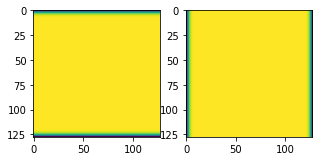

In [6]:
from jwave.discretization import Coordinate
from jwave.core import Field
from matplotlib import pyplot as plt

# Construct the PML field
coordinate_discr = Coordinate(domain)
X = Field(coordinate_discr, params={}, name="X")

delta_pml = 54.

@operator()
def pml_fun(X):
    on_pml = jops.elementwise(
        lambda x: jnp.where(
            jnp.abs(x) > delta_pml,
            (jnp.abs(jnp.abs(x)-delta_pml)/(64. - delta_pml)), 
            0.)
    )
    alpha = 4.*on_pml(X)**4
    return jops.elementwise(jnp.exp)((-1)*alpha*dt/2)

# Discretize it on the grid
pml_field = pml_fun(X=X)
global_params = pml_field.get_global_params()
pml_on_grid = pml_field.get_field_on_grid(0)(global_params, {'X': {}})

# Show field example
fig, ax = plt.subplots(1,2,figsize=(5,12))
ax[0].imshow(pml_on_grid[...,0])
ax[1].imshow(pml_on_grid[...,1])

In [7]:
from jwave.discretization import RealFourierSeries
from jax import random

seeds = random.split(random.PRNGKey(42), 20)

# Defining discretization
fourier_discr = CustomFourier(domain)
fourier_discr_2D = CustomFourier(domain, dims=2)

# Defining the field parameters needed for simulation 
# and the corresponding objects
c, c_f = fourier_discr.random_field(seeds[0],name="c")
p, p_f = fourier_discr.random_field(seeds[1],name="p")
rho, rho_f = fourier_discr.random_field(seeds[2],name="rho")
rho0, rho0_f = fourier_discr_2D.random_field(seeds[3],name="rho0")
Source_f, SF_f = fourier_discr_2D.random_field(seeds[4],name="Source_f")
Source_m, SM_f = fourier_discr_2D.random_field(seeds[5],name="Source_m")
tau, tau_f = fourier_discr.random_field(seeds[6],name="tau")
u, u_f = fourier_discr_2D.random_field(seeds[7],name="u")

# Numerical functions
_du = du(rho0=rho0_f, p=p_f, Source_f=SF_f)
gp_du = _du.get_global_params()
def du_f(gp, rho0, p, Sf):
    return _du.get_field_on_grid(0)(gp,{"rho0": rho0, "p": p, "Source_f": Sf})

_drho = drho(u=u_f, rho0=rho0_f, tau=tau_f, Source_m=SM_f)
gp_drho = _du.get_global_params()
def drho_f(gp, u, rho0, tau, Sm):
    return _drho.get_field_on_grid(0)(gp,{"u":u,"rho0":rho0,"tau":tau,"Source_m":Sm})

_p_new = p_new(c=c_f, rho=rho_f)
gp_pnew = _p_new.get_global_params()
def p_new_f(gp, c, rho):
    return _p_new.get_field_on_grid(0)(gp, {"c":c, "rho":rho})

In [8]:
drho_f(gp_drho, u, rho0, tau, Source_m).shape

(128, 128, 2)

In [9]:
du_f(gp_du, rho0, p, Source_f).shape

(128, 128, 2)

In [10]:
p_new_f(gp_pnew, c, rho).shape

(128, 128, 1)

In [12]:
u_f

Field :: CustomFourier, [[[-0.64510894 -0.37119263]
  [ 1.0143577  -0.7761091 ]
  [ 1.3669407  -0.64136314]
  ...
  [-0.7599168   0.84769416]
  [ 1.1967567   0.10120466]
  [ 0.10812864 -1.1539396 ]]

 [[-0.5165     -1.0231291 ]
  [-0.6648872  -0.19004029]
  [-1.3338366  -2.6127114 ]
  ...
  [ 1.6957669   1.1184759 ]
  [-0.98199683 -0.06940181]
  [-0.7863541   0.4976504 ]]

 [[ 0.20917772 -1.0799445 ]
  [-0.707841    1.0429755 ]
  [ 0.4812198   0.3291315 ]
  ...
  [ 0.9142207   2.5905943 ]
  [ 0.23728026  0.937987  ]
  [-1.2130866   0.04217006]]

 ...

 [[-1.9971613  -1.1707602 ]
  [ 0.00934171 -0.15025818]
  [-0.08032867 -0.680741  ]
  ...
  [ 1.469074    0.7240181 ]
  [-0.0103779   0.82080567]
  [ 1.5164819   0.11834317]]

 [[-1.7500764  -0.69036216]
  [-1.1011686  -2.4007707 ]
  [ 0.8133764   0.1826685 ]
  ...
  [-1.451048    0.40904683]
  [ 0.95020497 -1.3083527 ]
  [ 0.8421445  -0.01388683]]

 [[ 0.44669998 -1.1268443 ]
  [-0.02136551  0.08117243]
  [ 0.76285416  1.1798182 ]
  ...
